In [1]:
import os
import json
import numpy as np
import pandas as pd
import datetime as dt

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_DATA = ''
path = os.path.join(PATH_DATA, 'csv')

# BW

In [3]:
class BW:
    
    def __init__(self, path):
        self.path = path
        self.files = os.listdir(path)
        self.stock = 'BW'
        self.start_date = dt.datetime(2019,2,22)  # Load data files from this date
        
    def load_books(self):
        files = [x for x in self.files if 'books' in x]
        files = [x for x in files if pd.to_datetime(x.split('.')[1]) > self.start_date]
        df = pd.DataFrame()
        for file in files:
            print(f'Loading {file} ...')
            df_file = pd.read_csv(os.path.join(self.path, file), sep=';', header=None)
            if len(df_file) > 0:
                df = pd.concat([df, df_file])
        df.columns = ['symbol', 'local_time', 'bids', 'asks']
        df.loc[:, 'local_time'] = pd.to_datetime(df['local_time'])
        return df.sort_values(by='local_time').reset_index(drop=True)
    
    def load_trades(self):
        files = [x for x in self.files if 'trades' in x]
        files = [x for x in files if pd.to_datetime(x.split('.')[1]) > self.start_date]
        df = pd.DataFrame()
        for file in files:
            print(f'Loading {file} ...')
            df_file = pd.read_csv(os.path.join(self.path, file), sep=';', header=None)
            if len(df_file) > 0:
                df = pd.concat([df, df_file])
        df.columns = ['symbol', 'tid', 'exch_time', 'local_time', 'price', 'size', 'side', 'amount']
        df.loc[:, 'exch_time'] = pd.to_datetime(df['exch_time'])
        df.loc[:, 'local_time'] = pd.to_datetime(df['local_time'])
        df.loc[:, 'side'] = df['side'].map({1: 2, 2: 1})
        return df.sort_values(by='local_time').reset_index(drop=True)
    
    def plotly_trades(self, trades_sample, best_bid, best_ask, symbol):
        
        base, quot = symbol.split('_')

        trace0 = go.Scatter(
            x = trades_sample[trades_sample['side'] == 2]['local_time'],
            y = trades_sample[trades_sample['side'] == 2]['price'],
            name = 'Market BUY',
            mode = 'markers',
            marker = dict(
                size = 10,
                color = '#3F4B7F',
                symbol = 'triangle-up',
                line = dict(
                    width = 0,
                    color = '#3F4B7F'
                )
            )
        )

        trace1 = go.Scatter(
            x = trades_sample[trades_sample['side'] == 1]['local_time'],
            y = trades_sample[trades_sample['side'] == 1]['price'],
            name = 'Market SELL',
            mode = 'markers',
            marker = dict(
                size = 10,
                color = 'rgb(76, 182, 170)',
                symbol = 'triangle-down',
                line = dict(
                    width = 0,
                )
            )
        )

        trace2 = go.Scatter(
            x = best_bid.iloc[::1].index,
            y = best_bid.iloc[::1],
            name = 'Best BID',
            mode = 'lines',
            marker = dict(
                size = 5,
                color = '#737CB4',
                symbol = 'line-ew',
                opacity= 1,
                line = dict(
                    width = 1,
                    color = '#737CB4'
                )
            ),
            line = dict(
                    shape = 'hv',
                )
        )

        trace3 = go.Scatter(
            x = best_ask.iloc[::1].index,
            y = best_ask.iloc[::1],
            name = 'Best ASK',
            mode = 'lines',
            marker = dict(
                size = 5,
                color = '#6AD2C5',
                symbol = 'line-ew',
                opacity= 1,
                line = dict(
                    width = 1,
                    color = '#6AD2C5'
                )
            ),
            line = dict(
                    shape = 'hv',
                )

        )

        data = [trace2, trace3, trace0, trace1]

        layout = dict(title = f'{base}/{quot} on {self.stock.upper()}',
                      yaxis = dict(zeroline = False),
                      xaxis = dict(zeroline = False)
                     )

        fig = dict(data=data, layout=layout)
        plotly.offline.iplot(fig, filename='trades')

In [4]:
xxx = BW(path)
books = xxx.load_books()
trades = xxx.load_trades()

stats = dict()

Loading bw.2019-02-22T01:46:08.179149.books.csv ...
Loading bw.2019-02-22T15:38:15.791066.books.csv.gz ...
Loading bw.2019-02-22T01:46:08.179149.books.csv.gz ...
Loading bw.2019-02-22T14:42:58.305378.books.csv ...
Loading bw.2019-02-22T15:38:15.791066.books.csv ...
Loading bw.2019-02-25T15:38:54.267968.books.csv ...
Loading bw.2019-02-22T15:38:15.791221.trades.csv ...
Loading bw.2019-02-22T14:42:58.305516.trades.csv ...
Loading bw.2019-02-22T01:46:08.179800.trades.csv ...
Loading bw.2019-02-25T15:38:54.268141.trades.csv ...


In [5]:
print(trades['symbol'].unique())

['EOS_USDT' 'BTC_USDT' 'ETH_USDT' 'EOS_BTC' 'BSV_BTC']


In [6]:
# Get sample time range (slow if > 2-4 hours)
time_start = dt.datetime(2019, 2, 22, 15, 30)
time_end = dt.datetime(2019, 2, 22, 17, 30)
symbol = 'EOS_BTC'
    
#Make sample
trades_sample = trades[trades['symbol'] == symbol]
trades_sample = trades_sample[(trades_sample['local_time'] > time_start) & 
                              (trades_sample['local_time'] < time_end)]
trades_sample.loc[:, 'price'] = trades_sample['price'].astype(float)
books_sample = books[books['symbol'] == symbol]
books_sample = books_sample[(books_sample['local_time'] > trades_sample['local_time'].min()) & 
                            (books_sample['local_time'] < trades_sample['local_time'].max())]
    
# Calculate best bid&ask
def get_best(x):
    x = json.loads(x)
    size = 0
    i = 0
#     bs = float(x[0][0])
    while size == 0:
        if i == len(x):
            return np.nan
        bs = float(x[i][0])
        size = float(x[i][1])
        i += 1
    return bs


best_bid = books_sample['bids'].apply(get_best)
best_ask = books_sample['asks'].apply(get_best)

best_bid.index = books_sample['local_time']
best_ask.index = books_sample['local_time']

best_bid = best_bid.loc[best_bid.shift() != best_bid].dropna()
best_ask = best_ask.loc[best_ask.shift() != best_ask].dropna()

best_bid.shape, best_ask.shape, trades_sample.shape

((2217,), (1510,), (4293, 8))

In [7]:
xxx.plotly_trades(trades_sample, best_bid, best_ask, symbol)

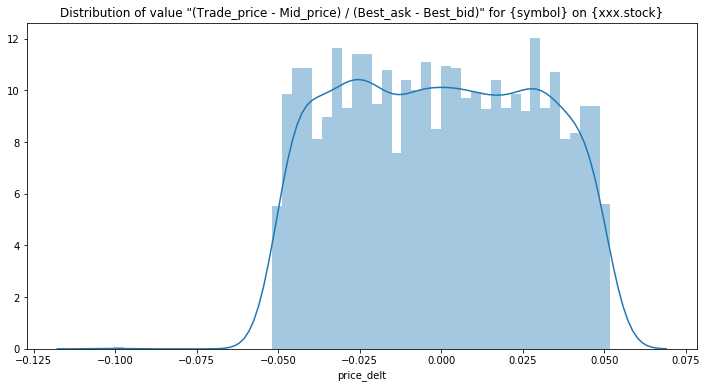

In [8]:
trades_seq = trades_sample[['local_time', 'price', 'size']].set_index('local_time', drop=True)

# Concatenating best_bid, best_ask and trades data
trades_mid_diff = pd.concat([trades_seq, best_bid]).rename(columns={0: 'best_bid'}).sort_index()
trades_mid_diff = pd.concat([trades_mid_diff, best_ask]).rename(columns={0: 'best_ask'}).sort_index()

# Calculating price delta
trades_mid_diff.loc[:, ['best_bid', 'best_ask']] = trades_mid_diff[['best_bid', 'best_ask']].ffill()
trades_mid_diff.dropna(inplace=True)
midprice = (trades_mid_diff['best_ask'] + trades_mid_diff['best_bid']) / 2
spread = trades_mid_diff['best_ask'] - trades_mid_diff['best_bid']
trades_mid_diff['price_delt'] = (midprice - trades_mid_diff['price']) / spread

# Plot distribution
plt.subplots(figsize=(12,6))
sns.distplot(trades_mid_diff['price_delt']
             , bins=50)
plt.title(f'Distribution of value "(Trade_price - Mid_price) / '
          '(Best_ask - Best_bid)" for {symbol} on {xxx.stock}')
plt.show();

In [9]:
count = trades_mid_diff.shape[0]
in_count = trades_mid_diff[trades_mid_diff['price_delt'].abs() < 0.49].shape[0]
volume = trades_mid_diff['size'].abs().sum()
in_volume = trades_mid_diff[trades_mid_diff['price_delt'].abs() < 0.49]['size'].abs().sum()

stats[symbol] = {'Trades Total': count, 
                 'In-spread Trades': in_count,
                 'Total Volume': volume,
                 'In-spread Volume': in_volume,
                 'In-spread Volume, %': in_volume / volume * 100}
stats

{'EOS_BTC': {'Trades Total': 4291,
  'In-spread Trades': 4291,
  'Total Volume': 5874.4200000000001,
  'In-spread Volume': 5874.4200000000001,
  'In-spread Volume, %': 100.0}}

In [10]:
stats_df = pd.DataFrame(stats).transpose()
stats_df['In-spread Volume, %']
stats_df.to_csv('stats.csv')
stats_df

,In-spread Trades,In-spread Volume,"In-spread Volume, %",Total Volume,Trades Total
EOS_BTC,4291.0,5874.42,100.0,5874.42,4291.0


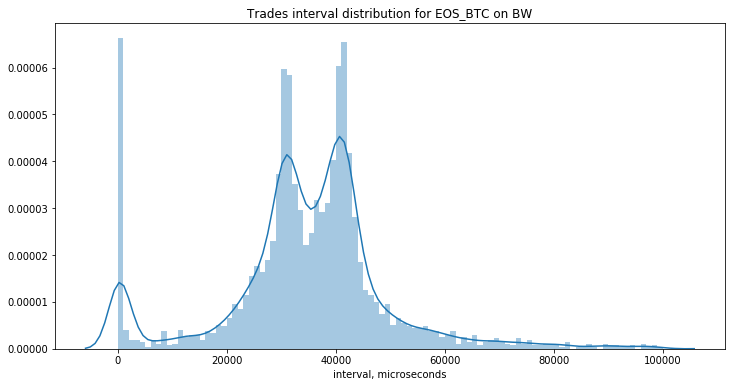

In [11]:
trades_int = (trades_sample['local_time'].diff().dt.seconds * 1e6 + 
              trades_sample['local_time'].diff().dt.microseconds).dropna()
trades_int = trades_int[trades_int >= 0]
plt.subplots(figsize=(12, 6))
sns.distplot(trades_int[trades_int < 1e5],  
             hist_kws={'range': (0, 1e5)},
             kde_kws={'clip': (0, 1e5)},
             bins=100)
plt.title(f'Trades interval distribution for {symbol} on {xxx.stock}')
plt.xlabel('interval, microseconds')
plt.show();

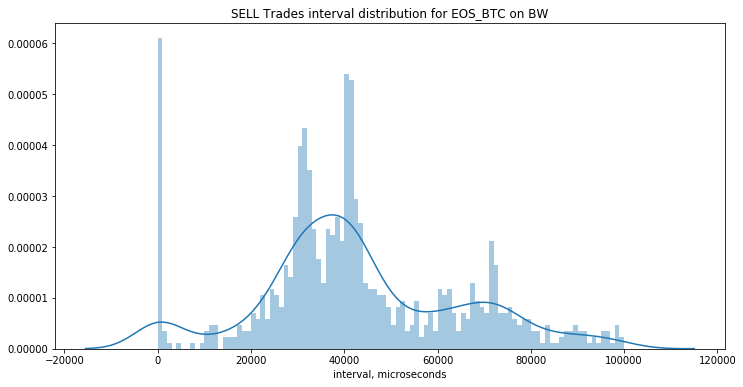

In [12]:
trades_int = (trades_sample['local_time'][trades_sample['side'] == 1].diff().dt.seconds * 1e6 + 
              trades_sample['local_time'][trades_sample['side'] == 1].diff().dt.microseconds).dropna()
trades_int = trades_int[trades_int >= 0]
plt.subplots(figsize=(12, 6))
sns.distplot(trades_int[trades_int < 1e5],  
             hist_kws={'range': (0, 1e5)},
             kde_kws={'clip': (0, 1e5)},
             bins=100)
plt.title(f'SELL Trades interval distribution for {symbol} on {xxx.stock}')
plt.xlabel('interval, microseconds')
plt.show();

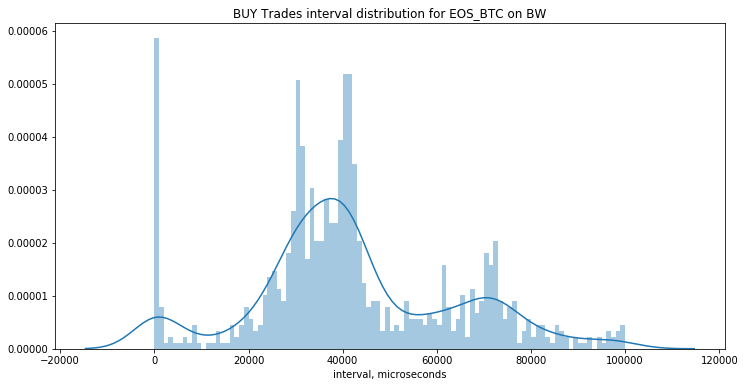

In [13]:
trades_int = (trades_sample['local_time'][trades_sample['side'] == 2].diff().dt.seconds * 1e6 + 
              trades_sample['local_time'][trades_sample['side'] == 2].diff().dt.microseconds).dropna()
trades_int = trades_int[trades_int >= 0]
plt.subplots(figsize=(12, 6))
sns.distplot(trades_int[trades_int < 1e5],  
             hist_kws={'range': (0, 1e5)},
             kde_kws={'clip': (0, 1e5)},
             bins=100)
plt.title(f'BUY Trades interval distribution for {symbol} on {xxx.stock}')
plt.xlabel('interval, microseconds')
plt.show();

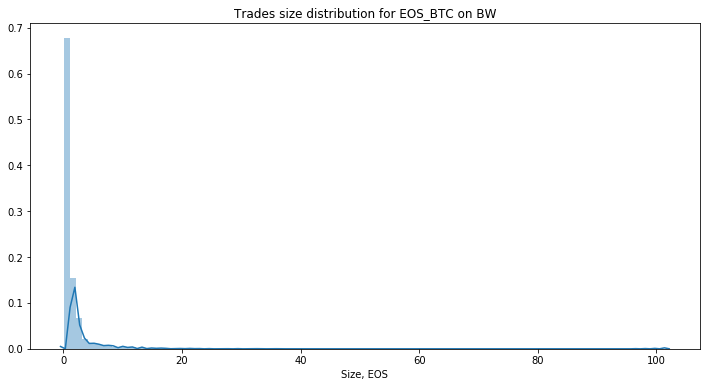

In [14]:

plt.subplots(figsize=(12, 6))
sns.distplot(trades_sample['size'][trades_sample['size'] < 50000], bins=100)
plt.title(f'Trades size distribution for {symbol} on {xxx.stock}')
plt.xlabel(f'Size, {symbol.split("_")[0]}')
plt.show();